# Stock Sentiment Analysis

This notebook performs sentiment analysis on news articles related to specific stocks and correlates it with stock price movements.

## 1. Setup and Imports

Import necessary libraries and modules from our `src` directory.

In [26]:
import pandas as pd
import sys
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Add src directory to path to import modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_fetcher import get_stock_data, get_news_articles

# Configure pandas display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

print("Setup complete.")

Setup complete.


## 2. Define Parameters

Set the stock ticker and date range for analysis.

In [27]:
TICKER = 'AAPL'  # Example: Apple Inc.
END_DATE = datetime.now().strftime('%Y-%m-%d')
# Fetch data for the last 30 days (adjust as needed)
# Note: NewsAPI free tier limits searches to the past month
START_DATE = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d') 

print(f"Ticker: {TICKER}")
print(f"Start Date: {START_DATE}")
print(f"End Date: {END_DATE}")

Ticker: AAPL
Start Date: 2025-03-31
End Date: 2025-04-30


## 3. Fetch Data

Use the functions from `data_fetcher.py` to get stock prices and news articles.

In [28]:
# Fetch Stock Data
print("Fetching stock data...")
stock_df = get_stock_data(TICKER, START_DATE, END_DATE)

if stock_df is not None:
    print(f"Successfully fetched {len(stock_df)} days of stock data.")
    display(stock_df.head())
else:
    print("Failed to fetch stock data.")

Fetching stock data...
Successfully fetched 21 days of stock data.


Date        Open        High         Low       Close     Volume  Dividends  Stock Splits
0  2025-03-31  217.009995  225.619995  216.229996  222.130005   65299300        0.0           0.0
1  2025-04-01  219.809998  223.679993  218.899994  223.190002   36412700        0.0           0.0
2  2025-04-02  221.320007  225.190002  221.020004  223.889999   35905900        0.0           0.0
3  2025-04-03  205.539993  207.490005  201.250000  203.190002  103419000        0.0           0.0
4  2025-04-04  193.889999  199.880005  187.339996  188.380005  125910900        0.0           0.0

In [29]:
# Fetch News Articles
print("Fetching news articles...")
articles_list = get_news_articles(TICKER, START_DATE, END_DATE)

# Convert the list of articles to a DataFrame
if articles_list is not None:
    news_df = pd.DataFrame(articles_list)
    # Convert publishedAt to datetime and extract date
    if 'publishedAt' in news_df.columns:
        news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'])
        news_df['date'] = news_df['publishedAt'].dt.date
    else:
        news_df['date'] = None # Handle case where publishedAt might be missing
else:
    news_df = pd.DataFrame() # Create an empty DataFrame if fetching failed

# Now check the DataFrame
if not news_df.empty:
    print(f"Successfully fetched and converted {len(news_df)} news articles to DataFrame.")
    display(news_df[['date', 'title', 'description', 'source']].head()) # Display relevant columns
else:
    print("No news articles found or failed to create DataFrame.")

Fetching news articles...
Found 853 articles for 'AAPL'
Successfully fetched and converted 100 news articles to DataFrame.
Found 853 articles for 'AAPL'
Successfully fetched and converted 100 news articles to DataFrame.


date                                              title                                        description                                       source
0  2025-04-14  AAPL opens market at highest price since Trump...  Apple opened trading on Monday, April 14, 2025...         {'id': None, 'name': 'AppleInsider'}
1  2025-04-03  Apple stock drops almost 10% on market open in...  Apple is a US-based company that relies heavil...              {'id': None, 'name': '9to5Mac'}
2  2025-04-25  Mag 7 earnings, PCE data, April jobs report: W...  Here's what investors are watching during the ...  {'id': None, 'name': 'Yahoo Entertainment'}
3  2025-04-10  AAPL crumble: stock hit again, as White House ...  After a brief respite on Wednesday, Apple's st...         {'id': None, 'name': 'AppleInsider'}
4  2025-04-28  Consumers get ahead of tariffs, Morgan Stanley...  Morgan Stanley hiked its Apple stock price tar...         {'id': None, 'name': 'AppleInsider'}

## 4. Sentiment Analysis

Apply sentiment analysis to the fetched news articles.

In [30]:
from src.sentiment_analyzer import analyze_sentiment
# Check if news_df exists and is not empty
if 'news_df' in locals() and not news_df.empty:
    print(f"Performing sentiment analysis on {len(news_df)} articles...")
    # Combine title and description for better context (handle None values)
    news_df['text_to_analyze'] = news_df['title'].fillna('') + ". " + news_df['description'].fillna('')
    # Apply the sentiment analysis function
    # This might take a while depending on the number of articles and your hardware
    sentiment_results = news_df['text_to_analyze'].apply(lambda x: analyze_sentiment(x) if pd.notna(x) else (None, None, None))
    # Unpack results into separate columns
    news_df['sentiment_label'] = sentiment_results.apply(lambda x: x[0])
    news_df['sentiment_score'] = sentiment_results.apply(lambda x: x[1])
    news_df['sentiment_scores_all'] = sentiment_results.apply(lambda x: x[2])
    # Display the results
    print("Sentiment analysis complete.")
    display(news_df[['date', 'title', 'sentiment_label', 'sentiment_score']].head())
    # Display value counts for sentiment labels
    print("\nSentiment Label Distribution:")
    print(news_df['sentiment_label'].value_counts())
else:
    print("Skipping sentiment analysis as no news articles were successfully fetched or the DataFrame is empty.")

Performing sentiment analysis on 100 articles...
Sentiment analysis complete.
Sentiment analysis complete.


date                                              title sentiment_label  sentiment_score
0  2025-04-14  AAPL opens market at highest price since Trump...        positive         0.926958
1  2025-04-03  Apple stock drops almost 10% on market open in...        negative         0.974071
2  2025-04-25  Mag 7 earnings, PCE data, April jobs report: W...         neutral         0.918775
3  2025-04-10  AAPL crumble: stock hit again, as White House ...        negative         0.971886
4  2025-04-28  Consumers get ahead of tariffs, Morgan Stanley...        positive         0.708044


Sentiment Label Distribution:
sentiment_label
negative    48
neutral     36
positive    16
Name: count, dtype: int64


## 5. Aggregate Sentiment and Merge Data

Aggregate the daily sentiment scores and merge them with the stock price data.

In [31]:
# Ensure 'date' column in news_df is datetime type if it exists
if 'news_df' in locals() and not news_df.empty and 'date' in news_df.columns:
    news_df['date'] = pd.to_datetime(news_df['date'])
    # Aggregate sentiment: Calculate the mean sentiment score per day
    # Filter out rows where sentiment_score might be None or NaN before aggregation
    valid_sentiment_df = news_df.dropna(subset=['sentiment_score'])
    daily_sentiment = valid_sentiment_df.groupby('date')['sentiment_score'].mean().reset_index()
    daily_sentiment.rename(columns={'sentiment_score': 'avg_sentiment_score'}, inplace=True)
    print("Daily aggregated sentiment:")
    display(daily_sentiment.head())

    # Ensure 'Date' column in stock_df is datetime type
    if 'stock_df' in locals() and stock_df is not None:
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        # Merge stock data with aggregated sentiment data
        merged_df = pd.merge(stock_df, daily_sentiment, left_on='Date', right_on='date', how='left')
        # Drop the redundant 'date' column from the sentiment df
        if 'date' in merged_df.columns:
             merged_df.drop(columns=['date'], inplace=True)
        print("\nMerged Stock and Sentiment Data:")
        display(merged_df.head())
    else:
        print("Stock data (stock_df) not available for merging.")
        merged_df = None # Set merged_df to None if stock data is missing
else:
    print("News data with sentiment (news_df) not available or empty. Cannot aggregate or merge.")
    merged_df = None # Set merged_df to None if news data is missing

Daily aggregated sentiment:


date  avg_sentiment_score
0 2025-03-31             0.889225
1 2025-04-01             0.710846
2 2025-04-02             0.846303
3 2025-04-03             0.850788
4 2025-04-04             0.833449


Merged Stock and Sentiment Data:


Date        Open        High         Low       Close     Volume  Dividends  Stock Splits  avg_sentiment_score
0 2025-03-31  217.009995  225.619995  216.229996  222.130005   65299300        0.0           0.0             0.889225
1 2025-04-01  219.809998  223.679993  218.899994  223.190002   36412700        0.0           0.0             0.710846
2 2025-04-02  221.320007  225.190002  221.020004  223.889999   35905900        0.0           0.0             0.846303
3 2025-04-03  205.539993  207.490005  201.250000  203.190002  103419000        0.0           0.0             0.850788
4 2025-04-04  193.889999  199.880005  187.339996  188.380005  125910900        0.0           0.0             0.833449

## 6. Visualize Data

Plot the stock closing price and the aggregated daily sentiment score over time.

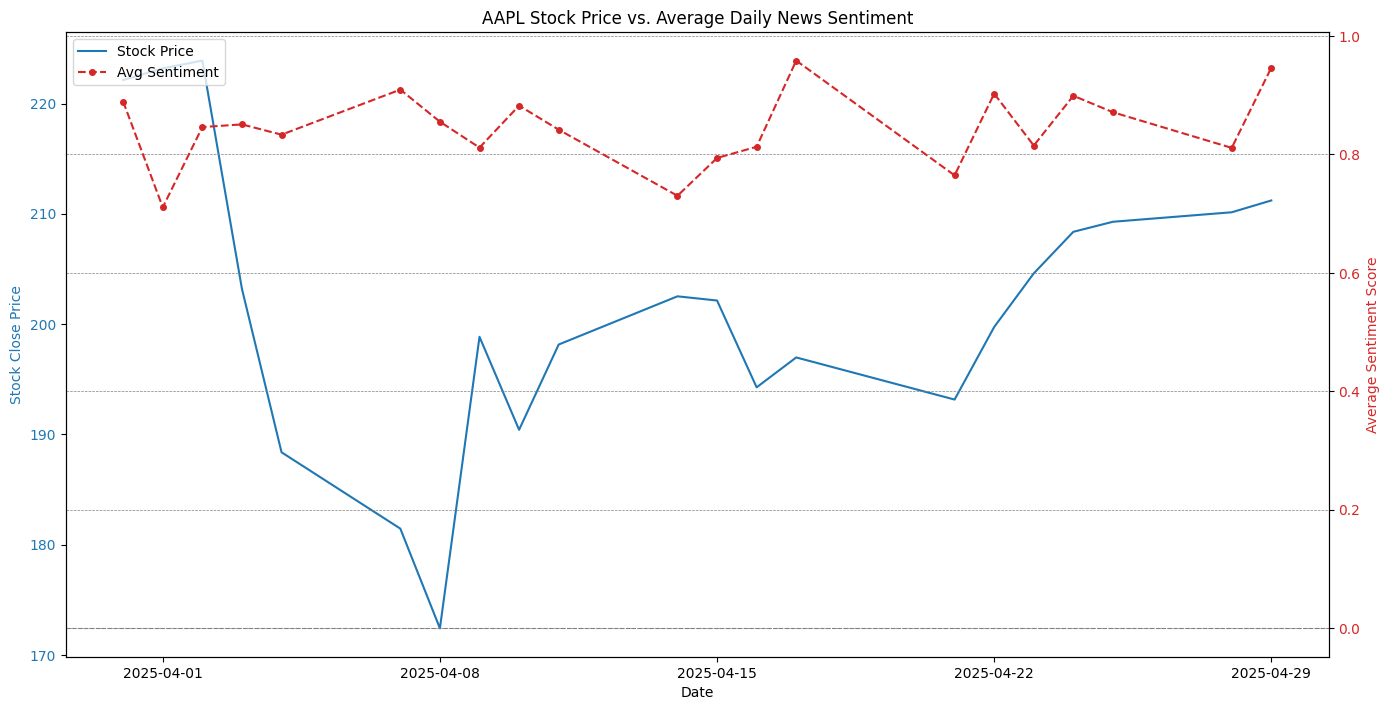

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if merged_df is not None and not merged_df.empty:
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Stock Price
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Close Price', color=color)
    ax1.plot(merged_df['Date'], merged_df['Close'], color=color, label='Stock Price')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for the sentiment score
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Sentiment Score', color=color)
    # Plot Sentiment Score - use points or dashed line to differentiate
    ax2.plot(merged_df['Date'], merged_df['avg_sentiment_score'], color=color, linestyle='--', marker='o', markersize=4, label='Avg Sentiment')
    ax2.tick_params(axis='y', labelcolor=color)
    # Add a horizontal line at sentiment score 0 for reference
    ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8)

    # Formatting
    fig.tight_layout() # Adjust layout to prevent overlap
    plt.title(f'{TICKER} Stock Price vs. Average Daily News Sentiment')
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) # Show weekly ticks
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    plt.show()
else:
    print("Merged data not available or empty. Cannot create visualization.")

## 7. Correlation Analysis

Calculate the correlation between daily sentiment scores and stock price changes.
We'll look at the correlation between sentiment on day D and price change from day D to day D+1.

In [33]:
if merged_df is not None and not merged_df.empty and 'avg_sentiment_score' in merged_df.columns:
    # Calculate daily percentage change in closing price
    merged_df['price_pct_change'] = merged_df['Close'].pct_change()

    # Shift sentiment scores to align sentiment from day D with price change from D to D+1
    merged_df['sentiment_lagged'] = merged_df['avg_sentiment_score'].shift(1)

    # Calculate correlation between lagged sentiment and price change
    # Drop NaN values that result from pct_change and shift
    correlation_df = merged_df[['sentiment_lagged', 'price_pct_change']].dropna()

    if not correlation_df.empty:
        correlation = correlation_df['sentiment_lagged'].corr(correlation_df['price_pct_change'])
        print(f"Correlation between lagged sentiment score and daily price change: {correlation:.4f}")

        # Display the relevant columns for inspection
        display(merged_df[['Date', 'Close', 'price_pct_change', 'avg_sentiment_score', 'sentiment_lagged']].head())
    else:
        print("Not enough overlapping data points to calculate correlation after lagging and calculating price change.")
else:
    print("Merged data not available, empty, or missing 'avg_sentiment_score'. Cannot calculate correlation.")

Correlation between lagged sentiment score and daily price change: -0.0235


Date       Close  price_pct_change  avg_sentiment_score  sentiment_lagged
0 2025-03-31  222.130005               NaN             0.889225               NaN
1 2025-04-01  223.190002          0.004772             0.710846          0.889225
2 2025-04-02  223.889999          0.003136             0.846303          0.710846
3 2025-04-03  203.190002         -0.092456             0.850788          0.846303
4 2025-04-04  188.380005         -0.072887             0.833449          0.850788